# **Imports and downloads**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving mtsamples.csv to mtsamples.csv


In [ ]:
! pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 8.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=b1d1f716d1d6a8bd9d185b695af0213c4fac2feeffaa5300c3ccfcdd6293709e
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import csv
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve

import tensorflow as tf
import tensorflow_datasets as td
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, BatchNormalization, Dropout

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **Data Preprocessing**

In [ ]:
mt = pd.read_csv('/content/mtsamples.csv')
mt.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [ ]:
mt.shape

(4999, 6)

In [ ]:
corpus = mt['transcription']
corpus.head()

0    SUBJECTIVE:,  This 23-year-old white female pr...
1    PAST MEDICAL HISTORY:, He has difficulty climb...
2    HISTORY OF PRESENT ILLNESS: , I have seen ABC ...
3    2-D M-MODE: , ,1.  Left atrial enlargement wit...
4    1.  The left ventricular cavity size and wall ...
Name: transcription, dtype: object

In [ ]:
corpus.shape

(4999,)

In [ ]:
# check for missing tweets in corpus
corpus.isna().sum().any()

True

In [ ]:
# drop Nan values
corpus = corpus.dropna()
corpus.shape

(4966,)

In [ ]:
# tokenization

# convert to regex pattern object
regex = re.compile('[^a-zA-Z]')

def tokenize(text):
    tokens = []
    for sentence in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sentence):
            sub_token = regex.sub('', word)
            tokens.append(sub_token.lower())
    return tokens

# sample tokenization
tokenized = tokenize(corpus[1][:100])
tokenized

['past',
 'medical',
 'history',
 '',
 '',
 'he',
 'has',
 'difficulty',
 'climbing',
 'stairs',
 '',
 'difficulty',
 'with',
 'airline',
 'seats',
 '',
 'tying',
 'shoes']

In [ ]:
# stopwords removal
stop_words = stopwords.words('english')
cleaned = [word for word in tokenized if word not in stop_words and word is not '']

# sample stopwords removal
cleaned[:10]

['past',
 'medical',
 'history',
 'difficulty',
 'climbing',
 'stairs',
 'difficulty',
 'airline',
 'seats',
 'tying']

In [ ]:
# stemming
stemmer = SnowballStemmer('english')

def stem(word):
    return stemmer.stem(word).strip()

# sample stemming
stemmed = [stem(word) for word in cleaned]
stemmed[:10]

['past',
 'medic',
 'histori',
 'difficulti',
 'climb',
 'stair',
 'difficulti',
 'airlin',
 'seat',
 'tie']

# **Topic Modeling - LDA**

In [ ]:
# TF-iDF
tfidf = TfidfVectorizer(max_df=0.8, max_features=10000,
                        min_df=0.05, stop_words=stop_words,
                        use_idf=True, tokenizer=tokenize,
                        lowercase=True, preprocessor=stem)

tfidf_matrix = tfidf.fit_transform(corpus)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', 'need', 'nt', 'onc', 'onli', 'ourselv', 'sha', 'shouldv', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv', 'youv'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
# LDA - 4 topics
lda = LatentDirichletAllocation(n_components=4, random_state=42)
lda.fit(tfidf_matrix);

# print topics and most recurring words
for i,topic in enumerate(lda.components_):
    print(f'Topic #{i}:')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Topic #0:
['seen', 'artery', 'evidence', 'ct', 'mild', 'unremarkable', 'exam', 'normal', 'left', 'right']


Topic #1:
['daily', 'po', 'also', 'pain', 'time', 'dr', 'discharge', 'day', 'history', 'mg']


Topic #2:
['neck', 'without', 'allergies', 'clear', 'negative', 'past', 'denies', 'normal', 'pain', 'history']


Topic #3:
['used', 'diagnosis', 'removed', 'incision', 'using', 'anesthesia', 'left', 'right', 'placed', 'procedure']




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# LDA visualization - pyldavis
pyLDAvis.sklearn.prepare(lda, tfidf_matrix, tfidf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.198932  0.064738       1        1  40.852360
2      0.128226  0.020052       2        1  26.839487
1      0.098978  0.062163       3        1  19.282688
0     -0.028272 -0.146954       4        1  13.025465, topic_info=          Term        Freq       Total Category  logprob  loglift
556      right  305.000000  305.000000  Default  30.0000  30.0000
430     normal  247.000000  247.000000  Default  29.0000  29.0000
339       left  294.000000  294.000000  Default  28.0000  28.0000
500  procedure  241.000000  241.000000  Default  27.0000  27.0000
382         mg  181.000000  181.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
722     within   34.493299   79.308755   Topic4  -4.9248   1.2057
51      artery   43.471938  113.886723   Topic4  -4.6935   1.0752
121         cm   36.079757  111.232778   Topic4  -4.8799   0.9124
374       mass   30.095958   81.798876   Topic4  -5.0612   1.0384
361      lower   31.404107  101.742885   Topic4  -5.0187   0.8628

[247 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.028778      abc
0         2  0.201447      abc
0         3  0.748233      abc
2         1  0.291683  abdomen
2         2  0.486138  abdomen
...     ...       ...      ...
728       3  0.260203        x
728       4  0.208163        x
730       2  0.297661      xyz
730       3  0.669737      xyz
730       4  0.024805      xyz

[627 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

In [ ]:
vocab = tfidf.get_feature_names()
# Generate a word cloud image for given topic
def generate_wordcloud(index):
  imp_words_topic=""
  comp = lda.components_[index]
  vocab_comp = zip(vocab, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic = imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


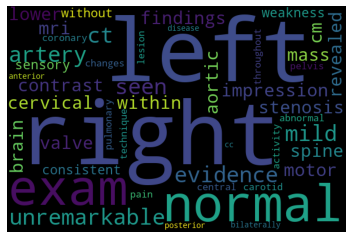

In [ ]:
# wordcloud for label 0 - Topic 1
generate_wordcloud(0)

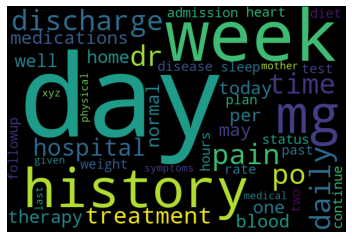

In [ ]:
# wordcloud for label 1 - Topic 2
generate_wordcloud(1)

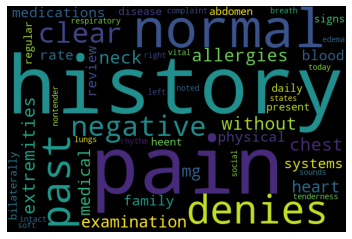

In [ ]:
# wordcloud for label 2 - Topic 3
generate_wordcloud(2)

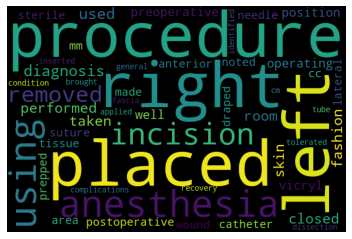

In [ ]:
# wordcloud for label 3 - Topic 4
generate_wordcloud(3)

In [ ]:
# generate list of words for each topic
def generate_topic_list(index):
  imp_words_topic=""
  comp = lda.components_[index]
  vocab_comp = zip(vocab, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic = imp_words_topic+" "+word[0]
  return imp_words_topic

In [ ]:
topic1_list = generate_topic_list(0)
topic2_list = generate_topic_list(1)
topic3_list = generate_topic_list(2)
topic4_list = generate_topic_list(3)

print(topic1_list)
print('\n')
print(topic2_list)
print('\n')
print(topic3_list)
print('\n')
print(topic4_list)

 right left normal exam unremarkable mild ct evidence artery seen impression mri contrast findings spine cm within stenosis cervical revealed motor lower c valve brain aortic mass sensory consistent weakness without coronary carotid lesion pain pelvis x technique central abnormal pulmonary changes activity throughout bilaterally disease anterior posterior cc l


 mg history day discharge dr time pain also po daily hospital treatment medications well weeks per therapy would one home blood today normal may days weight sleep followup x plan test heart admission disease continue rate status two hours week diet past symptoms physical since medical given last mother xyz


 history pain normal denies past negative clear allergies without neck chest extremities examination mg heart medical medications systems rate blood family physical review present heent bilaterally regular abdomen signs daily disease respiratory breath tenderness sounds lungs states intact also nontender edema soft left vit

In [ ]:
# jaccard distance
def jaccard(list1, list2):
  intersection = len(list(set(list1).intersection(list2)))
  union = (len(list1) + len(list2)) - intersection
  return float(intersection) / union

# topic 1 
print('Similarity between topic 1 and other topics')
print(jaccard(topic1_list, topic2_list))
print(jaccard(topic1_list, topic3_list))
print(jaccard(topic1_list, topic4_list))
print('\n')
# topic 2
print('Similarity between topic 2 and other topics')
print(jaccard(topic2_list, topic1_list))
print(jaccard(topic2_list, topic3_list))
print(jaccard(topic2_list, topic4_list))
print('\n')
# topic 3
print('Similarity between topic 3 and other topics')
print(jaccard(topic3_list, topic1_list))
print(jaccard(topic3_list, topic2_list))
print(jaccard(topic3_list, topic4_list))
print('\n')
# topic 4
print('Similarity between topic 4 and other topics')
print(jaccard(topic4_list, topic1_list))
print(jaccard(topic4_list, topic2_list))
print(jaccard(topic4_list, topic3_list))

Similarity between topic 1 and other topics
0.037209302325581395
0.033946251768033946
0.03168044077134986


Similarity between topic 2 and other topics
0.037209302325581395
0.03680981595092025
0.03427719821162444


Similarity between topic 3 and other topics
0.033946251768033946
0.03680981595092025
0.03137789904502047


Similarity between topic 4 and other topics
0.03168044077134986
0.03427719821162444
0.03137789904502047


# **Dataframe creation for classification**

In [ ]:
# topic labelling
topic_values = lda.transform(tfidf_matrix)

# creating new dataset for text classification after labelling
df = pd.DataFrame({'text': corpus, 'label': topic_values.argmax(axis=1)})
df.groupby(['label']).count().unstack()

      label
text  0         665
      1         899
      2        1173
      3        2229
dtype: int64

In [ ]:
df.head(10)

,text,label
0,"SUBJECTIVE:, This 23-year-old white female pr...",2
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",2
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",1
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",0
4,1. The left ventricular cavity size and wall ...,0
5,"PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POST...",3
6,"PREOPERATIVE DIAGNOSES:,1. Deformity, right b...",3
7,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",0
8,"PREOPERATIVE DIAGNOSIS: , Lipodystrophy of the...",3
9,"DESCRIPTION:,1. Normal cardiac chambers size....",0


In [ ]:
import csv

data = df
with open('mt_classify.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(data)

# **Deep learning model**

In [ ]:
# extract text and labels
sentences = df['text'].tolist()
labels = df['label'].tolist()

# display sample
for i in range (5):
    print(sentences[i][:100])
    print(labels[i])
    print("\n")

SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have 
2


PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes
2


HISTORY OF PRESENT ILLNESS: , I have seen ABC today.  He is a very pleasant gentleman who is 42 year
1


2-D M-MODE: , ,1.  Left atrial enlargement with left atrial diameter of 4.7 cm.,2.  Normal size righ
0


1.  The left ventricular cavity size and wall thickness appear normal.  The wall motion and left ven
0




In [ ]:
# Tokenization
vocab_size = 1000
tokenizer = td.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=7)
print("Vocab size: ", tokenizer.vocab_size)

Vocab size:  1002


In [ ]:
# sample tokenization
print(sentences[1][:100])
encoded = tokenizer.encode(sentences[1][:100])
print(encoded)

PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes
[826, 428, 194, 446, 453, 252, 260, 171, 778, 106, 69, 666, 266, 331, 18, 222, 520, 103, 61, 118, 218, 861, 3, 666, 266, 331, 18, 14, 538, 860, 698, 778, 42, 86, 861, 3, 336, 25, 578, 102]


In [ ]:
# display each subword separately
for i in encoded:
    print(tokenizer.decode([i]))

P
AS
T 
MED
ICA
L 
HISTORY
:,
 
He 
has 
dif
fic
ult
y 
cl
im
bi
ng 
sta
ir
s
, 
dif
fic
ult
y 
with 
ai
r
line
 
se
at
s
, 
ty
ing 
sho
es


In [ ]:
# replace the sentences with tokenized/encoded subwords
for i, sentence in enumerate(sentences):
    sentences[i] = tokenizer.encode(sentence)
    
print(sentences[1][:100])

[826, 428, 194, 446, 453, 252, 260, 171, 778, 106, 69, 666, 266, 331, 18, 222, 520, 103, 61, 118, 218, 861, 3, 666, 266, 331, 18, 14, 538, 860, 698, 778, 42, 86, 861, 3, 336, 25, 578, 102, 3, 473, 9, 625, 493, 162, 42, 413, 201, 3, 4, 29, 210, 25, 347, 852, 215, 8, 409, 489, 2, 228, 857, 43, 1, 106, 147, 31, 105, 659, 778, 629, 606, 238, 8, 11, 81, 847, 224, 52, 67, 595, 4, 73, 74, 126, 50, 857, 1, 106, 69, 666, 266, 331, 18, 149, 854, 682, 207, 449]


In [ ]:
# padding all sequences
max_length = 30
trunc_type = 'post'
padding_type = 'post'

padded = pad_sequences(sentences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)

In [ ]:
# split into training and testing data
train_size = int(len(sentences)*0.8)

train_sequences = padded[0:train_size]
test_sequences = padded[train_size:]
train_labels = labels[0:train_size]
test_labels = labels[train_size:]

# convert labels into numpy arrays
train_labels_array = np.array(train_labels)
test_labels_array = np.array(test_labels)

In [ ]:
# define model
embedding_dim = 64

model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    GlobalAveragePooling1D(), 
    BatchNormalization(),
    Dense(12, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 64)            64000     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 12)                780       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [ ]:
import tensorflow
from tensorflow.keras.optimizers import Adam
epochs = 24
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])
history = model.fit(train_sequences, train_labels_array, epochs=epochs, validation_data=(test_sequences, test_labels_array), shuffle=True, batch_size=32)

Epoch 1/24
125/125 [==============================] - 2s 6ms/step - loss: 0.0000e+00 - accuracy: 0.1737 - val_loss: 0.0000e+00 - val_accuracy: 0.2254
Epoch 2/24
125/125 [==============================] - 1s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1644 - val_loss: 0.0000e+00 - val_accuracy: 0.2254
Epoch 3/24
125/125 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1679 - val_loss: 0.0000e+00 - val_accuracy: 0.2254
Epoch 4/24
125/125 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1624 - val_loss: 0.0000e+00 - val_accuracy: 0.2254
Epoch 5/24
125/125 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.1631 - val_loss: 0.0000e+00 - val_accuracy: 0.2254
Epoch 6/24
125/125 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1664 - val_loss: 0.0000e+00 - val_accuracy: 0.2254
Epoch 7/24
125/125 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1

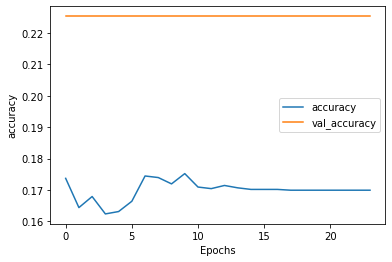

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")

# **Naive Bayes model**

In [ ]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, X_train, y_train, X_test, y_test):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0: 'Topic 1', 
                                        1: 'Topic 2', 
                                        2: 'Topic 3',
                                        3: 'Topic 4'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    
    return visualizer

In [ ]:
size = int(len(df) * 0.8)
train_data = df[:size]
test_data = df[size:]
print(train_data.shape)
print(test_data.shape)

(3972, 2)
(994, 2)


In [ ]:
count_vectorizer = CountVectorizer()
tfidf_transformer = TfidfTransformer()

X_train_count = count_vectorizer.fit_transform(train_data.text)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_count)

print(X_train_count.shape)
print(X_train_tfidf.shape)
print("\n")

X_test_count = count_vectorizer.transform(test_data.text)
X_test_tfidf = tfidf_transformer.transform(X_test_count)

print(X_test_count.shape)
print(X_test_tfidf.shape)

(3972, 21906)
(3972, 21906)


(994, 21906)
(994, 21906)


In [ ]:
# define NB model
model_nb = MultinomialNB().fit(X_train_tfidf, train_data.label)

In [ ]:
predicted_nb = model_nb.predict(X_test_tfidf)

In [ ]:
print(accuracy_score(test_data.label, predicted_nb))
print("\n")
print(confusion_matrix(test_data.label, predicted_nb))

0.8319919517102615


[[ 38   8   6  54]
 [  0 132  71  21]
 [  0   1 452   6]
 [  0   0   0 205]]


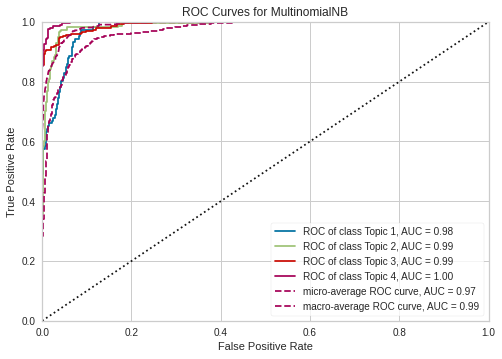

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f3938c8e1d0>,
       encoder={0: 'Topic 1', 1: 'Topic 2', 2: 'Topic 3', 3: 'Topic 4'},
       estimator=MultinomialNB())

In [ ]:
plot_ROC_curve(model_nb, X_train_tfidf, train_data.label, X_test_tfidf, test_data.label)

# **SVM model**

In [ ]:
# define SVC model
model_svc = SVC(C=1)
model_svc.fit(X_train_tfidf, train_data.label)

SVC(C=1)

In [ ]:
predicted_svc = model_svc.predict(X_test_tfidf)

In [ ]:
print(accuracy_score(test_data.label, predicted_svc))
print("\n")
print(confusion_matrix(test_data.label, predicted_svc))

0.9758551307847082


[[102   1   0   3]
 [  3 207  14   0]
 [  1   1 457   0]
 [  1   0   0 204]]


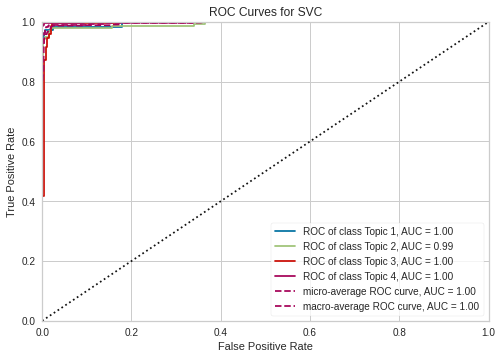

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f3933ddd710>,
       encoder={0: 'Topic 1', 1: 'Topic 2', 2: 'Topic 3', 3: 'Topic 4'},
       estimator=SVC(C=1))

In [ ]:
plot_ROC_curve(model_svc, X_train_tfidf, train_data.label, X_test_tfidf, test_data.label)

# **Save SVM model**

In [ ]:
import pickle
filename = 'text_classifier.pkl'
pickle.dump(model_svc, open(filename, 'wb'))

In [ ]:
# predict on new input
input = ["Patient is a pleasant 37-year-old gentleman who has had multiple procedures including a laparotomy related to trauma. The patient has had a recurrently infected cyst of his mass at the superior aspect of his incision, which he says gets larger and then it drains internally, causing him to be quite ill. He presented to my office and I recommended that he undergo exploration of this area and removal. The procedure, purpose, risks, expected benefits, potential complications, and alternative forms of therapy were discussed with him and he was agreeable to surgery."]
input_count = count_vectorizer.transform(input)
input_tfidf = tfidf_transformer.transform(input_count)
input_prediction = model_svc.predict(input_tfidf)
print(input_prediction)

[1]
